## Amazon Bedrock Text-to-SQL Evaluation

### Intro and Goal
This Jupyter Notebook is designed to illustrate Text-to-SQL evaluation.

The goal is to take highlight programmatic evaluation metrics as well as LLM as a Judge.

The notebook is structured as follows:
1. Download ground truth dataset comprised of questions and SQL queries for a given database (e.g. Northwind)
2. Evaluate accuracy, cost, and latency of different Text-to-SQL approaches compared to the baseline (zero-shot prompting) for all queries.

In [ ]:
# 1. Create a python environment

# !conda create -y --name bedrock-router-eval python=3.11.8
# !conda init && activate bedrock-router-eval
# !conda install -n bedrock-router-eval ipykernel --update-deps --force-reinstall -y
# !conda install -c conda-forge ipython-sql

## OR
# !python -m venv venv
# !source venv/bin/activate  # On Windows, use `venv\Scripts\activate`

In [ ]:
# 2. Install dependencies

# !pip install -r requirements.txt

In [39]:
# 3. Import necessary libraries and load environment variables

import numpy as np
from scipy.spatial.distance import cdist
import json
from dotenv import load_dotenv, find_dotenv
import os
import boto3
import sqlite3
from pandas.io import sql
from botocore.config import Config
import pandas as pd
import io
import json
from io import StringIO
import sqlparse
import sqlite3
import time
import matplotlib.pyplot as plt
import re
import typing as t
from queue import Queue
from threading import Thread
from concurrent.futures import ThreadPoolExecutor, as_completed

# loading environment variables that are stored in local file
local_env_filename = 'dev.env'
load_dotenv(find_dotenv(local_env_filename),override=True)

os.environ['REGION'] = os.getenv('REGION')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
os.environ['SQL_DATABASE'] = os.getenv('SQL_DATABASE') # LOCAL, SQLALCHEMY, REDSHIFT
os.environ['SQL_DIALECT'] = os.getenv('SQL_DIALECT') # SQlite, PostgreSQL


REGION = os.environ['REGION']
HF_TOKEN = os.environ['HF_TOKEN']
SQL_DATABASE = os.environ['SQL_DATABASE']
SQL_DIALECT = os.environ['SQL_DIALECT']

MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0" #anthropic.claude-3-sonnet-20240229-v1:0" # anthropic.claude-3-haiku-20240307-v1:0 "anthropic.claude-3-5-sonnet-20240620-v1:0" "meta.llama3-1-70b-instruct-v1:0"
EVAL_MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

# get ground truth data
file_path = './data/ground_truth.jsonl'
groundtruth_df = pd.read_json(file_path, lines=True)

print(f"Using database: {SQL_DATABASE} with sql dialect: {SQL_DIALECT}")

Using database: SQLALCHEMY with sql dialect: PostgreSQL


In [43]:
# 4. Definition of helper classes

class BedrockLLMWrapper():
    def __init__(self,
        model_id: str = 'anthropic.claude-3-sonnet-20240229-v1:0', # 'anthropic.claude-3-haiku-20240307-v1:0', #'anthropic.claude-3-sonnet-20240229-v1:0',
        top_k: int = 5,
        top_p: int = 0.7,
        temperature: float = 0.0,
        max_token_count: int = 4000,
        max_attempts: int = 3,
        debug: bool = False

    ):

        self.model_id = model_id
        self.top_k = top_k
        self.top_p = top_p
        self.temperature = temperature
        self.max_token_count = max_token_count
        self.max_attempts = max_attempts
        self.debug = debug
        config = Config(
            retries = {
                'max_attempts': 10,
                'mode': 'standard'
            }
        )

        self.bedrock_runtime = boto3.client(service_name="bedrock-runtime", config=config, region_name=REGION)
        
    def generate(self,prompt):
        if self.debug: 
            print('entered BedrockLLMWrapper generate')
        attempt = 1

        message = {
            "role": "user",
            "content": [{"text": prompt}]
        }
        messages = []
        messages.append(message)
        
        # model specific inference parameters to use.
        if "anthropic" in self.model_id.lower():
            # system_prompts = [{"text": "You are a helpful AI Assistant."}]
            system_prompts = []
            # Base inference parameters to use.
            inference_config = {
                                "temperature": self.temperature, 
                                "maxTokens": self.max_token_count,
                                "stopSequences": ["\n\nHuman:"],
                                "topP": self.top_p,
                            }
            additional_model_fields = {"top_k": self.top_k}
        else:
            system_prompts = []
            # Base inference parameters to use.
            inference_config = {
                                "temperature": self.temperature, 
                                "maxTokens": self.max_token_count,
                            }
            additional_model_fields = {"top_k": self.top_k}

        if self.debug: 
            print("Sending:\nSystem:\n",system,"\nMessages:\n",str(messages))

        while True:
            try:

                # Send the message.
                response = self.bedrock_runtime.converse(
                    modelId=self.model_id,
                    messages=messages,
                    system=system_prompts,
                    inferenceConfig=inference_config,
                    additionalModelRequestFields=additional_model_fields
                )

                # Log token usage.
                text = response['output'].get('message').get('content')[0].get('text')
                usage = response['usage']
                latency = response['metrics'].get('latencyMs')

                if self.debug: 
                    print(f'text: {text} ; and token usage: {usage} ; and query_time: {latency}')    
                
                break
               
            except Exception as e:
                print("Error with calling Bedrock: "+str(e))
                attempt+=1
                if attempt>self.max_attempts:
                    print("Max attempts reached!")
                    result_text = str(e)
                    break
                else:#retry in 10 seconds
                    print("retry")
                    time.sleep(10)

        # return result_text
        return [text,usage,latency]

     # Threaded function for queue processing.
    def thread_request(self, q, results):
        while True:
            try:
                index, prompt = q.get(block=False)
                data = self.generate(prompt)
                results[index] = data
            except Queue.Empty:
                break
            except Exception as e:
                print(f'Error with prompt: {str(e)}')
                results[index] = str(e)
            finally:
                q.task_done()

    def generate_threaded(self, prompts, max_workers=15):
        results = [None] * len(prompts)
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_index = {executor.submit(self.generate, prompt): i for i, prompt in enumerate(prompts)}
            for future in as_completed(future_to_index):
                index = future_to_index[future]
                try:
                    results[index] = future.result()
                except Exception as exc:
                    print(f'Generated an exception: {exc}')
                    results[index] = str(exc)
        
        return results

class Util():
    def __init__(self,
        debug: bool = False

    ):
        self.debug = debug
    
    SCORE_PATTERN = r'<score>(.*?)</score>'
    REASONING_PATTERN = r'<thinking>(.*?)</thinking>'
    SQL_PATTERN = r'<[sS][qQ][lL]>(.*?)</[sS][qQ][lL]>'
    DIFFICULTY_PATTERN = r'<difficulty>(.*?)</difficulty>'
    USER_QUESTION_PATTERN = r'<user_question>(.*?)</user_question>'
    SQL_DATABASE_SCHEMA_PATTERN = r'<sql_database_schema>(.*?)</sql_database_schema>'
    SQL_DIALECT_PATTERN = r'<sql_dialect>(.*?)</sql_dialect>'


    def compare_results(self, answer_results1, answer_results2):


        # # Function to convert 'score' column
        def convert_score(df):
            # df['score'] = df['score'].map({'correct': 1, 'incorrect': 0})
            df['score'] = pd.to_numeric(df['score'], errors='coerce').fillna(0).astype(int)
            return df

        # Apply the conversion to both dataframes
        answer_results1 = convert_score(answer_results1)
        answer_results2 = convert_score(answer_results2)

        # Calculate the average values for each metric
        metrics = ['score', 'latency' ,'cost', 'ex_score', 'em_score','ves_score']
        
        avg_results1 = [answer_results1[metric].mean() for metric in metrics]
        avg_results2 = [answer_results2[metric].mean() for metric in metrics]

        # Calculate percentage change, handling divide-by-zero and infinite cases
        def safe_percent_change(a, b):
            if pd.isna(a) or pd.isna(b):
                return 0
            if a == 0 and b == 0:
                return 0
            elif a == 0:
                return 100  # Arbitrarily set to 100% increase if original value was 0
            else:
                change = (b - a) / a * 100
                return change if np.isfinite(change) else 0

        percent_change = [safe_percent_change(a, b) for a, b in zip(avg_results1, avg_results2)]

        # Set up the bar chart
        x = np.arange(len(metrics))
        width = 0.5

        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the bars
        bars = ax.bar(x, percent_change, width)

        # Customize the chart
        ax.set_ylabel('Percentage Change (%)')
        ax.set_title('Percentage Change in Metrics (Results 2 vs Results 1)')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)

        # Add a horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

        # Add value labels on top of each bar
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}%',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3 if height >= 0 else -3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom' if height >= 0 else 'top')

        autolabel(bars)

        # Color the bars based on positive (green) or negative (red) change
        # For latency & cost, reverse the color logic
        for bar, change, metric in zip(bars, percent_change, metrics):
            if metric == 'latency' or metric == 'cost':
                bar.set_color('green' if change <= 0 else 'red')
            else:
                bar.set_color('green' if change >= 0 else 'red')
            

        # Adjust layout and display the chart
        fig.tight_layout()
        plt.show()

    def visualize_distribution(self, df, key):
        # Check if 'score' column exists in the DataFrame
        if key not in df.columns:
            raise ValueError(f"The DataFrame does not contain a '{key}' column.")
        
        # Count the frequency of each score
        score_counts = df[key].value_counts().sort_index()
        
        # Create a bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(score_counts.index, score_counts.values)
        
        # Customize the chart
        plt.title(f'Distribution of {key}')
        plt.xlabel(f'{key}')
        plt.ylabel('Frequency')
        plt.xticks(range(int(score_counts.index.min()), int(score_counts.index.max()) + 1))
        
        # Add value labels on top of each bar
        for i, v in enumerate(score_counts.values):
            plt.text(score_counts.index[i], v, str(v), ha='center', va='bottom')
        
        # Display the chart
        plt.tight_layout()
        plt.show()

    # Strip out the portion of the response with regex.
    def extract_with_regex(self, response, regex):
        matches = re.search(regex, response, re.DOTALL)
        # Extract the matched content, if any
        return matches.group(1).strip() if matches else None

    def calculate_cost(self, usage, model_id):
        '''
        Takes the usage tokens returned by Bedrock in input and output, and coverts to cost in dollars.
        '''
        
        input_token_haiku = 0.25/1000000
        output_token_haiku = 1.25/1000000
        input_token_sonnet = 3.00/1000000
        output_token_sonnet = 15.00/1000000
        input_token_opus = 15.00/1000000
        output_token_opus = 75.00/1000000
        
        input_token_titan_embeddingv1 = 0.1/1000000
        input_token_titan_embeddingv2 = 0.02/1000000
        input_token_titan_embeddingmultimodal = 0.8/1000000
        input_token_titan_premier = 0.5/1000000
        output_token_titan_premier = 1.5/1000000
        input_token_titan_lite = 0.15/1000000
        output_token_titan_lite = 0.2/1000000
        input_token_titan_express = 0.2/1000000
        output_token_titan_express = 0.6/1000000
       
        input_token_cohere_command = 0.15/1000000
        output_token_cohere_command = 2/1000000
        input_token_cohere_commandlight = 0.3/1000000
        output_token_cohere_commandlight = 0.6/1000000
        input_token_cohere_commandrplus = 3/1000000
        output_token_cohere_commandrplus = 15/1000000
        input_token_cohere_commandr = 5/1000000
        output_token_cohere_commandr = 1.5/1000000
        input_token_cohere_embedenglish = 0.1/1000000
        input_token_cohere_embedmultilang = 0.1/1000000

        input_token_llama3_8b = 0.4/1000000
        output_token_llama3_8b = 0.6/1000000
        input_token_llama3_70b = 2.6/1000000
        output_token_llama3_70b = 3.5/1000000

        input_token_mistral_8b = 0.15/1000000
        output_token_mistral_8b = 0.2/1000000
        input_token_mistral_large = 4/1000000
        output_token_mistral_large = 12/1000000

        cost = 0

        if 'haiku' in model_id:
            cost+= usage['inputTokens']*input_token_haiku
            cost+= usage['outputTokens']*output_token_haiku
        if 'sonnet' in model_id:
            cost+= usage['inputTokens']*input_token_sonnet
            cost+= usage['outputTokens']*output_token_sonnet
        if 'opus' in model_id:
            cost+= usage['inputTokens']*input_token_opus
            cost+= usage['outputTokens']*output_token_opus
        if 'amazon.titan-embed-text-v1' in model_id:
            cost+= usage['inputTokens']*input_token_titan_embeddingv1
        if 'amazon.titan-embed-text-v2' in model_id:
            cost+= usage['inputTokens']*input_token_titan_embeddingv2
        if 'cohere.embed-multilingual' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_embedmultilang
        if 'cohere.embed-english' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_embedenglish 
        if 'meta.llama3-8b-instruct' in model_id:
            cost+= usage['inputTokens']*input_token_llama3_8b
            cost+= usage['outputTokens']*output_token_llama3_8b
        if 'meta.llama3-70b-instruct' in model_id:
            cost+= usage['inputTokens']*input_token_llama3_70b
            cost+= usage['outputTokens']*output_token_llama3_70b
        if 'cohere.command-text' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_command
            cost+= usage['outputTokens']*output_token_cohere_command
        if 'cohere.command-light-text' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandlight
            cost+= usage['outputTokens']*output_token_cohere_commandlight
        if 'cohere.command-r-plus' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandrplus
            cost+= usage['outputTokens']*output_token_cohere_commandrplus
        if 'cohere.command-r' in model_id:
            cost+= usage['inputTokens']*input_token_cohere_commandr
            cost+= usage['outputTokens']*output_token_cohere_commandr
        if 'amazon.titan-text-express' in model_id:
            cost+= usage['inputTokens']*input_token_titan_express
            cost+= usage['outputTokens']*output_token_titan_express
        if 'amazon.titan-text-lite' in model_id:
            cost+= usage['inputTokens']*input_token_titan_lite
            cost+= usage['outputTokens']*output_token_titan_lite
        if 'amazon.titan-text-premier' in model_id:
            cost+= usage['inputTokens']*input_token_titan_premier
            cost+= usage['outputTokens']*output_token_titan_premier
        if 'mistral.mixtral-8x7b-instruct-v0:1' in model_id:
            cost+= usage['inputTokens']*input_token_mistral_8b
            cost+= usage['outputTokens']*output_token_mistral_8b

        return cost


# Utility class to get database schema, create tables, and run SQL queries
import requests
import sqlite3
import re
from pyathena import connect
# import psycopg2
from sqlalchemy import create_engine, MetaData, text


class DatabaseUtil():
    def __init__(self,
        debug: bool = False,
        datasource_url: [] = ['https://d3q8adh3y5sxpk.cloudfront.net/sql-workshop/data/redshift-sourcedb.sql'],
        sql_database: str = 'LOCAL',
        sql_database_name: str = 'dev',
        region: str = 'us-east-1',
        s3_bucketname: str = ''

    ):
        self.debug = debug
        self.datasource_url = datasource_url
        self.sql_database = sql_database
        self.sql_database_name = sql_database_name
        self.region = region
        self.s3_bucketname = s3_bucketname

    # retrieve AWS secret for database connection
    def get_secret(self, secret_name):
        session = boto3.session.Session()
        client = session.client(service_name='secretsmanager', region_name=self.region)
        get_secret_value_response = client.get_secret_value(SecretId=secret_name)
        return get_secret_value_response

    def get_table_reflections(self, engine) -> MetaData:
    
        # Instantiate MetaData object
        metadata = MetaData()
        
        # Reflect the database schema with the engine
        metadata.reflect(bind=engine)
        
        return metadata

    def convert_reflection_to_dict(self, metadata: MetaData) -> dict:
        table_definitions: list[dict] = []
        for table_name in metadata.tables:
            definition = {}
            definition['table'] = table_name
            # The metadata.table[x].columns value is type sqlalchemy.sql.base.ReadOnlyColumnCollection
            # Lets convert it into something more usable. c.type returns a SQLAlchemy object so we convert to string.
            definition['columns'] = { c.name: str(c.type) for c in metadata.tables[table_name].columns }
        
            table_header = f"Table: {table_name}"
            columns_definition = '\n'.join([f"Column: {c.name}, Type: {c.type}" for c in metadata.tables[table_name].columns])
            string_representation = f"{table_header}\n{columns_definition}"
        
            definition['string_representation'] = string_representation
        
            table_definitions.append(definition)
        
        
        # The metadata table is a FacadeDict object which is immutable so we need to remove unwanted tables in the new list.
        table_names_to_exclude = set(['table_embedding', 'alembic_version'])
        table_definitions = [d for d in table_definitions if d['table'] not in table_names_to_exclude]

        return table_definitions
    
    def create_database_tables(self):
        # Download the SQL files
        
            # create local db and import northwind database
            for url in self.datasource_url:
                response = requests.get(url)
                sql_content = response.text
                # Split the SQL content into individual statements
                sql_statements = re.split(r';\s*$', sql_content, flags=re.MULTILINE)
                
                if self.sql_database == 'LOCAL':
                    try:
                        # Create a SQLite database connection
                        conn = sqlite3.connect('devdb.db')
                        cursor = conn.cursor()

                        # Execute each SQL statement
                        for statement in sql_statements:
                            # Skip empty statements
                            if statement.strip():
                                # print(f'statement: {statement}')
                                # Replace PostgreSQL-specific syntax with SQLite equivalents
                                statement = statement.replace('SERIAL PRIMARY KEY', 'INTEGER PRIMARY KEY AUTOINCREMENT')
                                statement = statement.replace('::int', '')
                                statement = statement.replace('::varchar', '')
                                statement = statement.replace('::real', '')
                                statement = statement.replace('::date', '')
                                statement = statement.replace('::boolean', '')
                                statement = statement.replace('public.', '')
                                statement = re.sub(r'WITH \(.*?\)', '', statement)
                                
                                try:
                                    cursor.execute(statement)
                                except sqlite3.Error as e:
                                    print(f"Error executing statement: {e}")

                        # Commit the changes and close the connection
                        conn.commit()
                        conn.close()

                        print("SQL execution completed.")
                    except Exception as e:
                        print(f"Error creating tables: {e}")
                        raise

                if self.sql_database == 'REDSHIFT':
                    try:
                        rdc = boto3.client('redshift-data')
                        get_secret_value_response = self.get_secret("RedshiftCreds")
                        # parse REDSHIFT_CLUSTER_DETAILS to extract WorkgroupName, Database, DbUser
                        WorkgroupName = json.loads(get_secret_value_response['SecretString']).get('workgroupname')
                        Database = json.loads(get_secret_value_response['SecretString']).get('workgroupname')
                        DbUser = json.loads(get_secret_value_response['SecretString']).get('username')

                        for statement in sql_statements:
                            try:        
                                rdc.execute_statement(
                                    WorkgroupName=WorkgroupName,
                                    Database=Database,
                                    DbUser=DbUser,
                                    Sql=statement
                                )
                                
                            except Exception as e:
                                print(f"Error executing statement: {e}")
                        print("SQL execution completed.")
                    except Exception as e:
                        print(f"Error creating tables: {e}")
                        raise
                
                if self.sql_database =='SQLALCHEMY':
                    # create tables in database
                    try:
                        # SQLALCHEMY_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{SQL_DATABASE_NAME}"
                        get_secret_value_response = self.get_secret("SQLALCHEMY_URL")
                        SQLALCHEMY_URL = get_secret_value_response['SecretString']

                        print(f"SQLALCHEMY_URL: {SQLALCHEMY_URL}")
                        engine = create_engine(SQLALCHEMY_URL)
                        with engine.connect() as connection:
                            # Execute each SQL statement
                            for statement in sql_statements:
                                # Skip empty statements
                                if statement.strip():
                                    # print(f'statement: {statement}')
                                    # Replace PostgreSQL-specific syntax with SQLite equivalents
                                    statement = statement.replace('SERIAL PRIMARY KEY', 'INTEGER PRIMARY KEY AUTOINCREMENT')
                                    statement = statement.replace('::int', '')
                                    statement = statement.replace('::varchar', '')
                                    statement = statement.replace('::real', '')
                                    statement = statement.replace('::date', '')
                                    statement = statement.replace('::boolean', '')
                                    statement = statement.replace('public.', '')
                                    statement = statement.replace('VARBYTE', 'bytea')
                                    statement = statement.replace('bpchar', 'varchar')
                                    
                                    statement = re.sub(r'WITH \(.*?\)', '', statement)
                                    
                                    try:
                                        connection.execute(text(statement))
                                    except Exception as e:
                                        print(f"Error executing statement: {e}")
                            connection.commit()
                            print("SQL execution completed.")    
                    except Exception as e:
                        print(f"Error creating tables: {e}")
                        raise


    def get_schema_as_string(self):
        if self.sql_database == 'LOCAL':
            db_path = 'devdb.db'          
            conn = sqlite3.connect(db_path)
            cursor = conn.cursor()

            # Query to get all table names
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = cursor.fetchall()

            schema_string = ""

            for table in tables:
                table_name = table[0]
                # Query to get the CREATE TABLE statement for each table
                cursor.execute(f"SELECT sql FROM sqlite_master WHERE type='table' AND name='{table_name}';")
                create_table_stmt = cursor.fetchone()[0]
                
                schema_string += f"{create_table_stmt};\n\n"

            conn.close()
            return schema_string

        if self.sql_database =='SQLALCHEMY':
            try:
                # Use SQLAlchemy if SQL Alchemy is used
                # SQLALCHEMY_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{SQL_DATABASE_NAME}"
                get_secret_value_response = self.get_secret("SQLALCHEMY_URL")
                SQLALCHEMY_URL = get_secret_value_response['SecretString']
                
                engine = create_engine(SQLALCHEMY_URL)
                metadata = self.get_table_reflections(engine)
                table_definitions = self.convert_reflection_to_dict(metadata)

                return table_definitions
                # with engine.connect() as connection:
                #     result = connection.execute("""""")
                #     return result.fetchall()
            except Exception as e:
                error = f"Error executing statement: {e}"
                print(error)

        if self.sql_database == "REDSHIFT":
            try:
                get_secret_value_response = self.get_secret("RedshiftCreds")
                # parse REDSHIFT_CLUSTER_DETAILS to extract WorkgroupName, Database, DbUser
                WorkgroupName = json.loads(get_secret_value_response['SecretString']).get('workgroupname')
                Database = json.loads(get_secret_value_response['SecretString']).get('workgroupname')
                DbUser = json.loads(get_secret_value_response['SecretString']).get('username')
                
                rdc = boto3.client('redshift-data')
                result = rdc.execute_statement(
                    WorkgroupName=WorkgroupName,
                    Database=Database,
                    DbUser=DbUser,
                    Sql=f"select * from pg_table_def where schemaname = 'public';"
                )
                return result
            except Exception as e:
                print(f"Error executing statement: {e}")
      
            
        if self.sql_database == 'GLUE':
            # use a Glue database
            table_names=None
            try:
                glue_client = boto3.client('glue', region_name=self.region)
                table_schema_list = []
                response = glue_client.get_tables(DatabaseName=self.sql_database_name)

                all_table_names = [table['Name'] for table in response['TableList']]

                if table_names:
                    table_names = [name for name in table_names if name in all_table_names]
                else:
                    table_names = all_table_names

                for table_name in table_names:
                    response = glue_client.get_table(DatabaseName=self.sql_database_name, Name=table_name)
                    columns = response['Table']['StorageDescriptor']['Columns']
                    schema = {column['Name']: column['Type'] for column in columns}
                    table_schema_list.append({"Table: {}".format(table_name): 'Schema: {}'.format(schema)})
            except Exception as e:
                print(f"Error: {str(e)}")
            return table_schema_list
        
    def run_sql(self, statement):
    
        if self.sql_database == 'LOCAL':
            try:
                # Create a SQLite database connection
                conn = sqlite3.connect('devdb.db')
                cursor = conn.cursor()

                cursor.execute(statement)
                # Fetch all rows from the result
                result = cursor.fetchall()
                conn.close()
                return result
            except sqlite3.Error as e:
                error = f"Error executing statement: {e}"
                raise
            
            finally:
                conn.close()
                
        if self.sql_database == 'GLUE':
            try:
                # Use Athena if AWS Glue Schema is used
                athenacursor = connect(s3_staging_dir=f"s3://{self.s3_bucketname}/athena/",
                                        region_name=self.region).cursor()
                athenacursor.execute(statement)
                result = pd.DataFrame(athenacursor.fetchall()).to_string(index=False)
                # convert df to string
                return result
            
            except Exception as e:
                error = f"Error executing statement: {e}"
                raise
        
        if self.sql_database == "REDSHIFT":
            try:
                get_secret_value_response = self.get_secret("RedshiftCreds")
                # parse REDSHIFT_CLUSTER_DETAILS to extract WorkgroupName, Database, DbUser
                WorkgroupName = json.loads(get_secret_value_response['SecretString']).get('workgroupname')
                Database = json.loads(get_secret_value_response['SecretString']).get('workgroupname')
                DbUser = json.loads(get_secret_value_response['SecretString']).get('username')

                rdc = boto3.client('redshift-data')
                result = rdc.execute_statement(
                    WorkgroupName=WorkgroupName,
                    Database=Database,
                    DbUser=DbUser,
                    Sql=statement
                )
                return result
                
            except Exception as e:
                error = f"Error executing statement: {e}"
                raise

        if self.sql_database =='SQLALCHEMY':
            try:
                # SQLALCHEMY_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{SQL_DATABASE_NAME}"
                get_secret_value_response = self.get_secret("SQLALCHEMY_URL")
                SQLALCHEMY_URL = get_secret_value_response['SecretString']
                
                engine = create_engine(SQLALCHEMY_URL)
                with engine.connect() as connection:
                    result = connection.execute(text(statement))
                    return result.fetchall()
            except Exception as e:
                error = f"Error executing statement: {e}"
                raise

class AnswerTaskRunner:
    def __init__(self, eval_df: pd.DataFrame, 
                 model_id:str = 'anthropic.claude-3-sonnet-20240229-v1:0',
                 eval_model_id:str = 'anthropic.claude-3-sonnet-20240229-v1:0',
                 sql_dialect=None,
                 temperature: float = 0.0,
                 max_token_count: int = 2000,
                 max_attempts: int = 3, 
                 prompt_template: str = '',
                 prompt_eval_template: str = '',
                 datasource_url: str =["https://d3q8adh3y5sxpk.cloudfront.net/sql-workshop/data/redshift-sourcedb.sql"],
                 sql_database: str = "LOCAL"):
        self.eval_df = eval_df
        self.model_id = model_id
        self.eval_model_id = eval_model_id
        self.sql_dialect = sql_dialect
        self.temperature = temperature
        self.max_token_count = max_token_count
        self.max_attempts = max_attempts
        self.prompt_template = prompt_template
        self.prompt_eval_template = prompt_eval_template
        self.datasource_url = datasource_url
        self.sql_database = sql_database
        self.wrapper = BedrockLLMWrapper(model_id=self.model_id, 
                                         max_token_count=self.max_token_count,
                                         temperature=self.temperature
                                         )
        self.eval_wrapper = BedrockLLMWrapper(model_id=self.eval_model_id, 
                                         max_token_count=self.max_token_count,
                                         temperature=self.temperature
                                         )
        self.util = Util()
        self.DatabaseUtil = DatabaseUtil(datasource_url=datasource_url,
                                         sql_database= self.sql_database)


    def get_prompt(self, user_question, sql_database_schema):
        prompt = self.prompt_template.format(
                    user_question=user_question,
                    sql_database_schema=sql_database_schema,
                    sql_dialect=self.sql_dialect
                ) 
        return prompt


    def build_grader_prompt(self, 
                            question: str, 
                            sql_schema: str, 
                            sql_query:str, 
                            sql_query_run_error, 
                            sql_query_run_result:str,
                            groundtruth_sql_query:str,
                            ex_score:str,
                            em_score:str,
                            ves_score:str):
    
        prompt = self.prompt_eval_template.format(
                    question=question,
                    sql_schema=sql_schema,
                    sql_query= sql_query,
                    sql_query_run_error= sql_query_run_error,
                    sql_query_run_result= sql_query_run_result,
                    groundtruth_sql_query= groundtruth_sql_query,
                    ex_score=ex_score,
                    em_score=em_score,
                    ves_score=ves_score,
                ) 
        return prompt


    def execution_accuracy(self, generated_sql, labeled_sql):
        """
        Calculate Execution Accuracy (EX)
        
        Args:
        generated_sql (str): The SQL query generated by the model
        labeled_sql (str): The labeled (ground truth) SQL query
        
        Returns:
        float: 1.0 if the queries match, 0.0 otherwise
        """
        # Normalize and compare the SQL queries
        gen_normalized = sqlparse.format(generated_sql, strip_comments=True, reindent=True)
        lab_normalized = sqlparse.format(labeled_sql, strip_comments=True, reindent=True)
        return 1.0 if gen_normalized == lab_normalized else 0.0

    def convert_to_str(self, result):
        if isinstance(result, list):
            return str(result)
        return result

    def exact_set_match_accuracy(self, generated_sql, labeled_sql):
        """
        Calculate Exact Set Match Accuracy (EM)
        
        Args:
        generated_sql (str): The SQL query generated by the model
        labeled_sql (str): The labeled (ground truth) SQL query
        db_connection: A database connection object
        
        Returns:
        float: 1.0 if the result sets match, 0.0 otherwise
        """
        try:
            # Execute both queries
            gen_result = self.DatabaseUtil.run_sql(generated_sql)
            # print(f'labeled_sql: {gen_result} - result: {gen_result}')
            lab_result = self.DatabaseUtil.run_sql(labeled_sql)
            # print(f'labeled_sql: {labeled_sql} - result: {lab_result}')
            gen_result = self.convert_to_str(gen_result)
            lab_result = self.convert_to_str(lab_result)

            # Compare the result sets
            return 1.0 if gen_result==lab_result else 0.0
        except Exception as e:
            return 0.0


    def valid_efficiency_score(self, generated_sql, labeled_sql):
        """
        Calculate Valid Efficiency Score (VES)
        
        Args:
        generated_sql (str): The SQL query generated by the model
        labeled_sql (str): The labeled (ground truth) SQL query
        db_connection: A database connection object
        
        Returns:
        float: The VES score
        """
        try:
            # Execute both queries and measure execution time
            gen_start = time.time()
            gen_result = self.DatabaseUtil.run_sql(generated_sql)
            gen_time = time.time() - gen_start
            # print(f'generated_sql_execution_time: {gen_time}')
            lab_start = time.time()
            lab_result = self.DatabaseUtil.run_sql(labeled_sql)
            lab_time = time.time() - lab_start
            # print(f'labeled_sql_execution_time: {lab_time}')
            
            gen_result = self.convert_to_str(gen_result)
            lab_result = self.convert_to_str(lab_result)

            # Check if results match
            if not gen_result==lab_result:
                return 0.0
            
            # Calculate VES
            ves = min(lab_time / gen_time, 1.0)
            return ves
        except Exception as e:
            print(f"Error executing SQL: {e}")
            return 0.0


    def run(self) -> pd.DataFrame:
        # Make a copy of the dataframe so we don't modify the original.
        df = pd.DataFrame(self.eval_df)
        results = []
        
        # Prepare prompts for all questions
        prompts = []
        for _, row in df.iterrows():
            question: str = row['Question']
            sql_database_schema: str = row['Context']
            model_prompt = self.get_prompt(question, sql_database_schema)
            prompts.append(model_prompt)
        
        # Generate SQL queries using threaded approach
        answers = self.wrapper.generate_threaded(prompts,max_workers=5)
        
        # bottleneck: from here on we are back to processing in sequence
        for index, (answer, row) in enumerate(zip(answers, df.iterrows())):
            _, row = row  # Unpack the row
            question: str = row['Question']
            sql_database_schema: str = row['Context']
            groundtruth_sql_query: str = row['Query']
            sql_query_run_error = None
            sql_query_run_result = None
            usage = 0
            latency = 0
            cost = 0
            ex_score = 0
            em_score = 0
            ves_score = 0

            if answer[1] is not None:
                cost = self.util.calculate_cost(answer[1], self.model_id)
                usage = json.dumps(answer[1])
            
            if answer[2] is not None:
                latency = answer[2]
            
            if answer[0] is not None:
                generated_sql_query = self.util.extract_with_regex(str(answer[0]), self.util.SQL_PATTERN).replace("\\","")
            
                # Calculate eval metrics
                try:
                    sql_query_run_result = self.DatabaseUtil.run_sql(generated_sql_query)
                except Exception as e:
                    sql_query_run_error = e
                
                # print(f'generated_sql: {generated_sql_query} - query_result: {sql_query_run_result}')
                
                ex_score = self.execution_accuracy(generated_sql_query, groundtruth_sql_query)
                # print(f'ex_score: {ex_score}')
                em_score = self.exact_set_match_accuracy(generated_sql_query, groundtruth_sql_query)
                # print(f'em_score: {em_score}')
                ves_score = self.valid_efficiency_score(generated_sql_query, groundtruth_sql_query)
                # print(f'ves_score: {ves_score}')
            
            # Create eval prompt
            prompt = self.build_grader_prompt(question=question, 
                                            sql_schema=sql_database_schema, 
                                            sql_query=generated_sql_query, 
                                            sql_query_run_error=sql_query_run_error,
                                            sql_query_run_result=sql_query_run_result,
                                            groundtruth_sql_query=groundtruth_sql_query,
                                            ex_score=ex_score,
                                            em_score=em_score,
                                            ves_score=ves_score)
            
            # Parse eval results
            eval_result = self.eval_wrapper.generate(prompt)
            reasoning = self.util.extract_with_regex(str(eval_result[0]), self.util.REASONING_PATTERN)
            score = self.util.extract_with_regex(str(eval_result[0]), self.util.SCORE_PATTERN)
            
            # Create new record
            result = {
                'user_question': question,
                'groundtruth_query': groundtruth_sql_query,
                'generated_sql_query': generated_sql_query,
                'score': score,
                'reasoning': reasoning,
                'usage': usage,
                'latency': latency,
                'cost': cost,
                'ex_score': ex_score,
                'em_score': em_score,
                'ves_score': ves_score,
                'sql_query_run_error': sql_query_run_error,
                'sql_query_run_result': sql_query_run_result,
                'context': sql_database_schema,
            }
            results.append(result)
        
        new_dataframe = pd.DataFrame(results)
        return new_dataframe

### Evaluation

In [44]:
# 5. Grading prompt

evaluation_template = """You are a SQL expert. 
                Your task is to evaluate a given SQL query based on a provided SQL schema and question using the criteria provided below.
 
                Evaluation Criteria (Additive Score, 0-5):
                1. Context: Award 1 point if the generated SQL query uses only information provided in the SQL schema, without introducing external or fabricated details.
                2. Completeness: Add 1 point if the generated SQL query addresses all key elements of the question based on the available SQL schema and Exact Set Match Accuracy (EM) score.
                3. ExecutionAccuracy: Add 1 point if the generated SQL query is very close to the groundtruth answer based on Execution Accuracy score.
                4. Faultless: Add 1 point if the generated SQL query ran without any errors.
                5. ValidEfficiencyScore:  Add 1 point if the runtime of the generated SQL query is similar or better than the the groundtruth qery as measured by the Valid Efficiency Score (VES).
                
                Evaluation Steps:
                1. Read provided context, question and answer carefully.
                2. Go through each evaluation criterion one by one and assess whether the answer meets the criteria.
                3. Compose your reasoning for each critera, explaining why you did or did not award a point. You can only award full points. 
                4. Calculate the total score by summing the points awarded.
                5. Think through the evaluation criteria inside <thinking></thinking> tags. 
                Then, output the total score inside <score></score> tags.
                Review your formatted response. It needs to be valid XML.
    
                Original question:
                <question>
                {question}
                </question>

                SQL schema:
                <sql_schema>
                {sql_schema}
                </sql_schema>

                Generated SQL query based on these instructions:
                <sql_query>
                {sql_query}
                </sql_query>

                SQL result based on the generated SQL query:
                <sql_query_run_result>
                {sql_query_run_result}
                </sql_query_run_result>

                Any SQL errors that might have occured based on the generated SQL query:
                <sql_query_run_error>
                {sql_query_run_error}
                </sql_query_run_error>

                Groundtruth SQL query for comparison with the generated SQL query:
                <groundtruth_sql_query>
                {groundtruth_sql_query}
                </groundtruth_sql_query>
                
                Execution Accuracy, which compares the generated SQL query to the labeled SQL query to determine if its a match or not: 
                <ex_score>
                {ex_score}
                </ex_score>
                
                Exact Set Match Accuracy (EM), which evaluates if the returned result set actually answer the question, regardless of how the query was written: 
                <em_score>
                {em_score}
                </em_score>

                Valid Efficiency Score (VES), which compares the runtime of the SQL provided as groundtruth to the generated SQL query:
                <ves_score>
                {ves_score}
                </ves_score>                
                """

In [53]:
# 6. Run eval with zero-shot template 
# Zero-shot SQL prompt template to establish baseline

## added "Always prefix table names with the "public." prefix." to support running queries via sqlalchemy 
zero_shot_sql_template = """You are a SQL expert. You will be provided with the original user question and a SQL database schema. 
                Only return the SQL query and nothing else.
                
                User question:
                <user_question>
                {user_question}
                </user_question>

                SQL database schema:
                <sql_database_schema>
                {sql_database_schema}
                </sql_database_schema>
                
                SQL dialect:
                <sql_dialect>
                {sql_dialect}
                </sql_dialect>

                Instructions:
                Generate a SQL query that answers the original user question.
                Use the schema, first create a syntactically correct {sql_dialect} query to answer the question. 
                Never query for all the columns from a specific table, only ask for a few relevant columns given the question.
                Always prefix table names with the "public." prefix.
                Pay attention to use only the column names that you can see in the schema description. 
                Be careful to not query for columns that do not exist. 
                Pay attention to which column is in which table. 
                Also, qualify column names with the table name when needed.
                If you cannot answer the user question with the help of the provided SQL database schema, 
                then output that this question question cannot be answered based of the information stored in the database.
                You are required to use the following format, each taking one line:
                Return the sql query inside the <sql></sql> tab.
                """



answer_results1: pd.DataFrame = AnswerTaskRunner(groundtruth_df[:10],
                 model_id=MODEL_ID,
                 eval_model_id=EVAL_MODEL_ID,
                 sql_database=SQL_DATABASE,
                 sql_dialect=SQL_DIALECT,
                 prompt_template=zero_shot_sql_template,
                 prompt_eval_template=evaluation_template).run()

answer_results1.to_json('./data/zero-shot-graded.jsonl', orient='records', lines=True, force_ascii=False, date_format='iso', default_handler=str)

In [56]:
answer_results1.head(5)

,user_question,groundtruth_query,generated_sql_query,score,reasoning,usage,latency,cost,ex_score,em_score,ves_score,sql_query_run_error,sql_query_run_result,context
0,What is the total number of customers?,SELECT COUNT(*) FROM customers;,SELECT COUNT(*) AS total_customers\nFROM custo...,4,Context (1 point):\nThe generated SQL query us...,"{""inputTokens"": 1532, ""outputTokens"": 23, ""tot...",637,0.000412,0.0,1.0,0.942588,None,[(91)],CREATE TABLE categories (\n category_id sma...
1,List all product names and their unit prices.,"SELECT product_name, unit_price FROM products;","SELECT p.product_name, p.unit_price\nFROM prod...",5,Context: The generated SQL query uses only the...,"{""inputTokens"": 1533, ""outputTokens"": 28, ""tot...",468,0.000418,0.0,1.0,1.000000,None,"[(Chai, 18.0), (Chang, 19.0), (Aniseed Syrup, ...",CREATE TABLE categories (\n category_id sma...
2,Who are the top 5 customers by order count?,"SELECT c.company_name, COUNT(o.order_id) as or...","SELECT customers.customer_id, customers.compan...",3,1. Context: The generated SQL query uses only ...,"{""inputTokens"": 1536, ""outputTokens"": 81, ""tot...",1098,0.000485,0.0,0.0,0.000000,None,"[(SAVEA, Save-a-lot Markets, 31), (ERNSH, Erns...",CREATE TABLE categories (\n category_id sma...
3,What is the average freight cost for orders?,SELECT AVG(freight) FROM orders;,SELECT AVG(o.freight) AS average_freight_cost\...,5,Context: The generated SQL query uses only the...,"{""inputTokens"": 1533, ""outputTokens"": 30, ""tot...",712,0.000421,0.0,1.0,0.702572,None,[(78.244204877492)],CREATE TABLE categories (\n category_id sma...
4,List all employees with their full names and t...,"SELECT employee_id, first_name || ' ' || last_...","SELECT e.first_name, e.last_name, e.title\nFRO...",2,Context:\nThe generated SQL query uses only th...,"{""inputTokens"": 1534, ""outputTokens"": 32, ""tot...",553,0.000423,0.0,0.0,0.000000,None,"[(Andrew, Fuller, Vice President, Sales), (Jan...",CREATE TABLE categories (\n category_id sma...


In [ ]:
# 7. Run eval with few-shot template  ( TO DO )
# Few-shot SQL prompt template to establish baseline
few_shot_sql_template = """You are a SQL expert. You will be provided with the original user question and a SQL database schema. 
                Only return the SQL query and nothing else.
                
                User question:
                <user_question>
                {user_question}
                </user_question>

                SQL database schema:
                <sql_database_schema>
                {sql_database_schema}
                </sql_database_schema>
                
                SQL dialect:
                <sql_dialect>
                {sql_dialect}
                </sql_dialect>

                Instructions:
                Generate a SQL query that answers the original user question.
                Use the schema, first create a syntactically correct {sql_dialect} query to answer the question. 
                Never query for all the columns from a specific table, only ask for a few relevant columns given the question.
                Pay attention to use only the column names that you can see in the schema description. 
                Be careful to not query for columns that do not exist. 
                Pay attention to which column is in which table. 
                Also, qualify column names with the table name when needed.
                If you cannot answer the user question with the help of the provided SQL database schema, 
                then output that this question question cannot be answered based of the information stored in the database.
                You are required to use the following format, each taking one line:
                Return the sql query inside the <sql></sql> tab.
                """

answer_results2: pd.DataFrame = AnswerTaskRunner(groundtruth_df,
                 model_id=MODEL_ID,
                 eval_model_id=EVAL_MODEL_ID,
                 sql_database=SQL_DATABASE,
                 sql_dialect=SQL_DIALECT,
                 prompt_template=few_shot_sql_template,
                 prompt_eval_template=evaluation_template).run()

answer_results2.to_json('./data/few-shot-graded.jsonl', orient='records', lines=True, force_ascii=False, date_format='iso', default_handler=str)

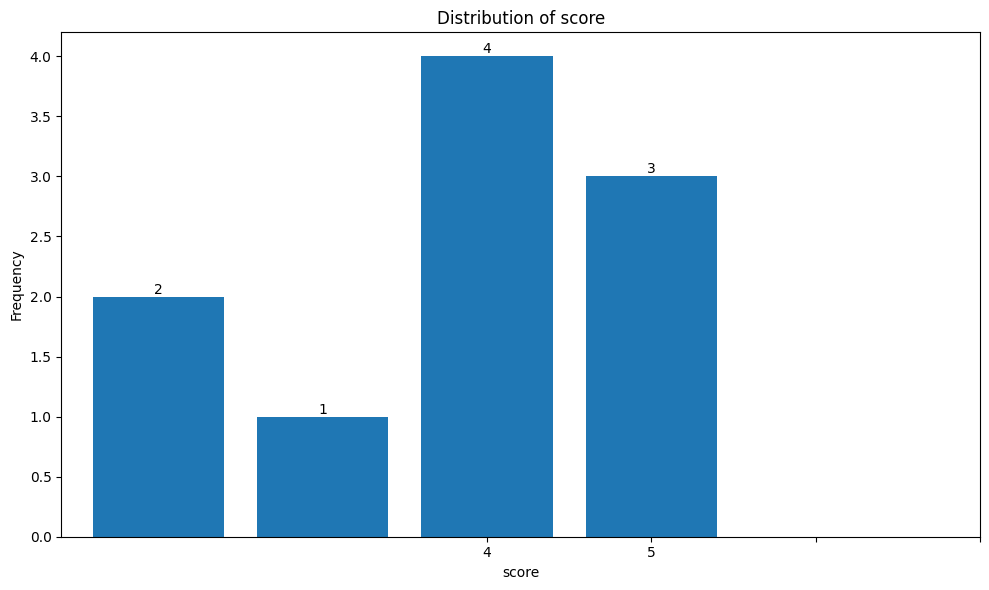

In [54]:
# 8. Compare results
util = Util()
# util.compare_results(answer_results2, answer_results1)
util.visualize_distribution(answer_results1,key='score')
# util.visualize_distribution(answer_results2,key='score')

In [55]:
# 9. Review results
print(f'sum of zero_shot_cost: {answer_results1["cost"].sum()}')
# print(f'sum of few_shot_cost: {answer_results2["cost"].sum()}')

print(f'avg of zero_shot_query_time: {answer_results1["latency"].mean()}')
# print(f'avg of few_shot_query_time: {answer_results2["latency"].mean()}')

# Execution Accuracy, which compares the generated router SQL query to the SQL query generated by the larger LLM to determine if its a match
print(f'avg of ex_score of zero_shot: {answer_results1["ex_score"].mean()}')
# Exact Set Match Accuracy (EM), which evaluates if the generated router SQL query resultset matches the SQL query generated resultset by the larger LLM
print(f'avg of em_score of zero_shot: {answer_results1["em_score"].mean()}')
# Valid Efficiency Score (VES), which compares the  generated router SQL query runtime provided to the generated SQL query from the larger LLM
print(f'avg of ves_score of zero_shot: {answer_results1["ves_score"].mean()}')

sum of zero_shot_cost: 0.0044065
avg of zero_shot_query_time: 1046.0
avg of ex_score of zero_shot: 0.0
avg of em_score of zero_shot: 0.6
avg of ves_score of zero_shot: 0.5567783791694143


In [ ]:
# 9. Run eval with finetuned LLM ( TO DO )

# 10. Compare results
util = Util()
util.compare_results(answer_results3, answer_results2)

In [ ]:
# 11. Review results (TO BE UPDATED)
print(f'sum of zero_cost: {answer_results1["cost"].sum()}')
print(f'sum of large_cost: {answer_results2["cost"].sum()}')

print(f'avg of small_query_time: {answer_results1["latency"].mean()}')
print(f'avg of large_query_time: {answer_results2["latency"].mean()}')

# Execution Accuracy, which compares the generated router SQL query to the SQL query generated by the larger LLM to determine if its a match
print(f'avg of ex_score of answer_results1: {answer_results1["ex_score"].mean()}')
# Exact Set Match Accuracy (EM), which evaluates if the generated router SQL query resultset matches the SQL query generated resultset by the larger LLM
print(f'avg of em_scoreof answer_results: {answer_results1["em_score"].mean()}')
# Valid Efficiency Score (VES), which compares the  generated router SQL query runtime provided to the generated SQL query from the larger LLM
print(f'avg of ves_score of answer_results1: {answer_results1["ves_score"].mean()}')

### Conclusion
XXX